## MOIRAI Usage Example

### Key features of the model:
- **Multi-patch Layers:** Adapts to different granularities (frequencies) - different patch size for each granularity
- **Probabilistic:** Predicts params of mix of distributions along with a confidence score for each distribution

### Loading MOIRAI Model

In [1]:
# External imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

src_path = os.path.abspath(os.path.join("src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Local imports
from samay.dataset import MoiraiDataset
from samay.model import MoiraiTSModel

# Load the pretrained model
repo = "Salesforce/moirai-moe-1.0-R-small"
config = {
        "context_len": 128,
        "horizon_len": 64,
        "num_layers": 100,
        "model_type": "moirai-moe",
        "model_size": "small"
    }

moirai_model = MoiraiTSModel(repo=repo, config=config)

In MoiraiTSModel init: type: <class 'samay.models.uni2ts.model.moirai_moe.forecast.MoiraiMoEForecast'>, patch_sizes: [16]


### Define the datasets

In [2]:
# Config for the electric transformer temperature dataset
data_config = {"name" : "ett",
                "path" : "../src/samay/models/moment/data/ETTh1.csv",
                "date_col" : "date",
                "freq": "h"
            }

df = pd.read_csv(data_config["path"])
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Here, we have 6 input features (all form `input_ts`) and the target column is the *Oil Temperature* (`OT`)

In [3]:
# test dataset - for zero-shot forecasting
test_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="test",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
)

Normalizing the dataset


### Evaluate zero-shot forecasting

In [4]:
%%time
eval_results, trues, preds, histories = moirai_model.evaluate(test_dataset, metrics=["MSE", "MASE"])
print(eval_results)

Forecasting done....now testing
{'MSE': 0.5570545342892568, 'MASE': 2.102492551231191}
CPU times: user 15.7 s, sys: 389 ms, total: 16.1 s
Wall time: 14 s


### Visualise forecast for a given window

In [5]:
random.seed(42)
window_index = random.randint(0, len(histories) - 1)
variate_no = random.randint(0, histories[window_index].shape[0] - 1)
print(f"Window index: {window_index}, Variate no: {variate_no}")

Window index: 40, Variate no: 0


In [6]:
history = histories[window_index][variate_no, -config["context_len"]:]
true = trues[window_index][variate_no, :]
pred = preds[window_index][variate_no, :]

len(history), len(true), len(pred)

(128, 64, 64)

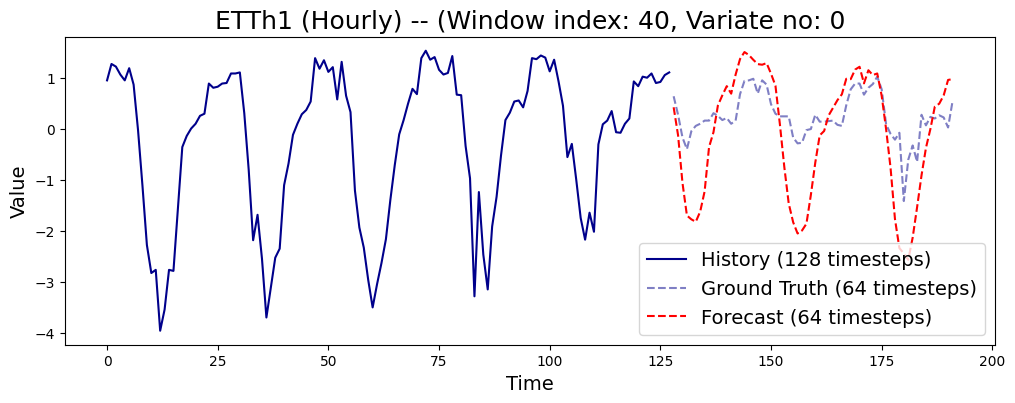

In [7]:
plt.figure(figsize=(12, 4))
num_forecasts = len(true)
offset = len(history)

# Plotting the first time series from history
plt.plot(range(offset), history, label=f"History ({offset} timesteps)", c="darkblue")

# Plotting ground truth and prediction
plt.plot(
    range(offset, offset + num_forecasts),
    true,
    label=f"Ground Truth ({num_forecasts} timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + num_forecasts),
    pred,
    label=f"Forecast ({num_forecasts} timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (Window index: {window_index}, Variate no: {variate_no}", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Finetune MOIRAI on ETT Dataset

In [8]:
import yaml

path = "../src/samay/models/uni2ts/cli/conf/finetune/model/moirai_small.yaml"
with open(path, "r") as file:
    fin_config = yaml.safe_load(file)

fin_config.keys()

dict_keys(['_target_', 'module_kwargs', 'min_patches', 'min_mask_ratio', 'max_mask_ratio', 'max_dim', 'loss_func', 'val_metric', 'lr', 'weight_decay', 'beta1', 'beta2', 'num_training_steps', 'num_warmup_steps', 'checkpoint_path'])

In [9]:
data_config_path = "../src/samay/models/uni2ts/cli/conf/finetune/default.yaml"
with open(data_config_path, "r") as file:
    torch_config = yaml.safe_load(file)
torch_config.keys()

dict_keys(['hydra', 'defaults', 'run_name', 'seed', 'tf32', 'compile', 'ckpt_path', 'trainer', 'train_dataloader', 'val_dataloader'])

In [10]:
# Number of input features to Input projection layer is the patch size used by the model
patch_size = moirai_model.model.module.in_proj.in_features_ls[0]
patch_size

16

In [11]:
# Train dataset
train_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="train",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
    patch_size=patch_size,
    kwargs=torch_config["train_dataloader"]
)

Normalizing the dataset


In [12]:
ft_kwargs = {"batch_size": torch_config["train_dataloader"]["batch_size"], "max_epochs": torch_config["trainer"]["max_epochs"], "seed": torch_config["seed"],
             "tf32": torch_config["tf32"], "mod_torch": {k:v for k,v in torch_config["trainer"].items() if k != "_target_" and type(v) not in [dict, list]}}

Epoch 0: Loss: -4.680
Epoch 1: Loss: -4.906
Epoch 2: Loss: -5.031
Epoch 3: Loss: -5.110
Epoch 4: Loss: -5.185
Finetuning done
Fineuned model updated
CPU times: user 10min 55s, sys: 1min 26s, total: 12min 22s
Wall time: 11min 42s


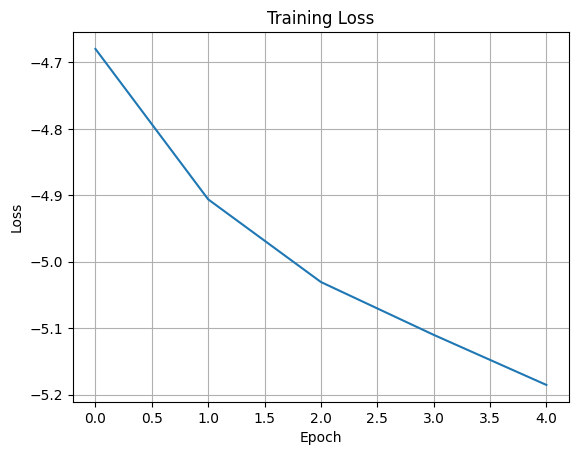

In [13]:
%%time
moirai_model.finetune(train_dataset, **ft_kwargs)

### Evaluate finetuned model

In [14]:
%%time
eval_results, trues, preds, histories = moirai_model.evaluate(test_dataset, metrics=["MSE", "MASE"],zero_shot=False)
print(eval_results)

Forecasting done....now testing
{'MSE': 0.5757764752501521, 'MASE': 2.09495189077425}
CPU times: user 14.1 s, sys: 112 ms, total: 14.2 s
Wall time: 12.4 s


### Visualise forecast for a given window

In [15]:
random.seed(42)
window_index = random.randint(0, len(histories) - 1)
variate_no = random.randint(0, histories[window_index].shape[0] - 1)
print(f"Window index: {window_index}, Variate no: {variate_no}")

Window index: 40, Variate no: 0


In [16]:
history = histories[window_index][variate_no, -config["context_len"]:]
true = trues[window_index][variate_no, :]
pred = preds[window_index][variate_no, :]

len(history), len(true), len(pred)

(128, 64, 64)

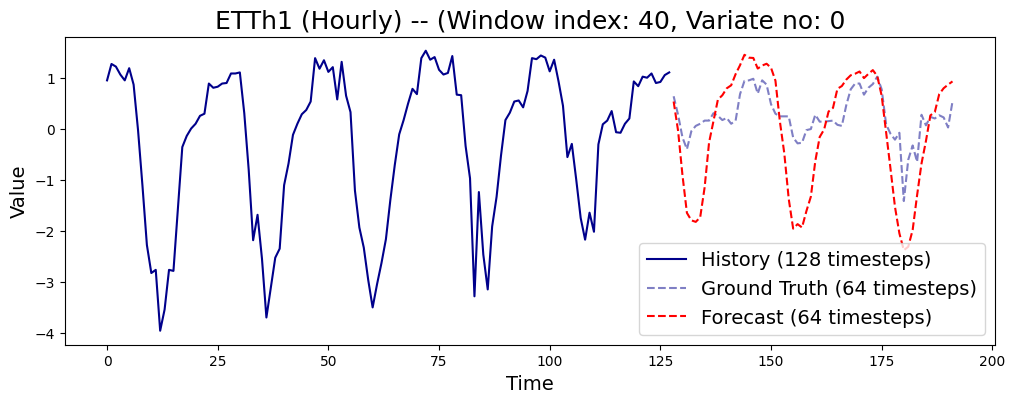

In [17]:
plt.figure(figsize=(12, 4))
num_forecasts = len(true)
offset = len(history)

# Plotting the first time series from history
plt.plot(range(offset), history, label=f"History ({offset} timesteps)", c="darkblue")

# Plotting ground truth and prediction
plt.plot(
    range(offset, offset + num_forecasts),
    true,
    label=f"Ground Truth ({num_forecasts} timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + num_forecasts),
    pred,
    label=f"Forecast ({num_forecasts} timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (Window index: {window_index}, Variate no: {variate_no}", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()